# Biomedical Semantic Search & Simplification Pipeline with a Transformers Model


## Summary
1. Required libraries
2. Data preprocessing

A. Encoder Part

3. Optimised encoder model configuration
4. Corpus encoding
5. Saving embeddings

B. Decoder Part

6. Decoder model configuration
7. Setting up user input for the chatbot

C. TF-IDF baseline

8. Evaluation
9. Prepare for evaluation
10. Metrics and results
11. Plot generation



### 1. Required libraries

In [1]:
# library installation
! pip install adapters transformers torch pandas tqdm numpy matplotlib -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.4/566.4 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 33.1 MB/s eta 0:00:00


### 2. Data preprocessing
Steps to load data into Google Colab:

1. Go to your Google Drive.

2. Create a folder called `Project_NLP`.

3. Drag `OptimusPrime_for_GoogleColab.ipynb` notebook into it and doble-click on it.

4. The CRUCIAL step:

- In the top right corner, click on the small arrow next to 'Sign in' (or 'RAM/Disk').

- Select Change runtime type.

- Choose T4 GPU.

In [5]:
import os
import urllib.request
from google.colab import drive
from pathlib import Path
from tqdm import tqdm


# Connection to the drive
drive.mount('/content/drive')
project_path = "/content/drive/MyDrive/Projet_NLP"

# Data repertory creation
local_path = "/content/data_temp"
os.makedirs(local_path, exist_ok=True)

# Uploading data files
files = [
    ("https://zenodo.org/records/14801641/files/relish_documents.tsv","relish_documents.tsv"),
    ("https://zenodo.org/records/14801641/files/relevance_matrix.tsv", "relevance_matrix.tsv")
]

def download_with_progress(url, destination_path):
    class DownloadProgressBar(tqdm):
        def update_to(self, b=1, bsize=1, tsize=None):
            if tsize is not None:
                self.total = tsize
            self.update(b * bsize - self.n)

    with DownloadProgressBar(unit='B', unit_scale=True, miniters=1, desc=os.path.basename(destination_path)) as t:
        urllib.request.urlretrieve(url, filename=destination_path, reporthook=t.update_to)

for url, filename in files:
    destination_path = os.path.join(project_path, filename)
    if not os.path.exists(destination_path):
        download_with_progress(url, destination_path)
    else:
        print(f"{filename} already exists in{local_path}. Download ignored.")

# 4. Verification
print("Files :")
print(os.listdir(local_path))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


relish_documents.tsv: 277MB [00:23, 12.0MB/s]                           
relevance_matrix.tsv: 4.74MB [00:01, 2.57MB/s]                            

Files :
['relish_documents.tsv', 'relevance_matrix.tsv']


In [6]:
import pandas as pd

# Connection to the drive
drive.mount('/content/drive')
# local_path = "Hands-on-NLP-Project"   # ⭐ Change your path


# Corpus loading
corpus_file = f"{project_path}/relish_documents.tsv"  # ⭐ Change your path

print("Loading corpus...")
corpus_df = pd.read_csv(corpus_file, sep='\t')

# Inspection structure
print(f"✓ Corpus: {len(corpus_df)} articles")

# Standardise column names
if 'PMID' in corpus_df.columns:
    corpus_df.rename(columns={'PMID': 'pmid', 'Title': 'title', 'Abstract': 'abstract'},
                     inplace=True)

# Cleaning up the corpus of articles without abstracts
corpus_df = corpus_df.dropna(subset=['abstract'])
corpus_df['pmid'] = corpus_df['pmid'].astype(str)

print(f"After cleaning: {len(corpus_df)} articles")
print(f"Columns: {corpus_df.columns.tolist()}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading corpus...
✓ Corpus: 163189 articles
After cleaning: 163189 articles
Columns: ['pmid', 'title', 'abstract']


## A. Encoder part
<a href="https://huggingface.co/allenai/specter2">Specter2</a> is chosen to vectorise the corpus It is capable of generating task specific embeddings for scientific tasks.

### 3. Optimised model configuration

In [7]:
import torch
from tqdm import tqdm
from transformers import AutoTokenizer
from adapters import AutoAdapterModel
from torch.cuda.amp import autocast

# Batch & device configuration
device = "cuda"
BATCH_SIZE = 128

print(f"device: {torch.cuda.get_device_name(0)}")

tokenizer = AutoTokenizer.from_pretrained('allenai/specter2_base')
model = AutoAdapterModel.from_pretrained('allenai/specter2_base')
model.load_adapter("allenai/specter2", source="hf", load_as="proximity", set_active=True)

# Forces activation of the proximity adapter
model.set_active_adapters("proximity")

#Verification of the use of 'proximity' (a list containing 'proximity')
print(f"Active adapter?{model.active_adapters}")

model.to(device)

device: Tesla T4


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/754 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

adapter_config.json: 0.00B [00:00, ?B/s]

pytorch_adapter.bin:   0%|          | 0.00/3.59M [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

Active adapter?Stack[proximity]


BertAdapterModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttentionWithAdapters(
              (query): LoRALinearTorch(
                in_features=768, out_features=768, bias=True
                (shared_parameters): ModuleDict()
                (loras): ModuleDict()
              )
              (key): LoRALinearTorch(
                in_features=768, out_features=768, bias=True
                (shared_parameters): ModuleDict()
                (loras): ModuleDict()
              )
              (value): LoRALinearTorch(
             

### 4. Corpus encoding

In [8]:
import numpy as np
import torch
from tqdm import tqdm

# mean pooling function
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

# encoding function
def encode_papers_optimized(papers_list, strategy="mean"):
    inputs = tokenizer(
        papers_list,
        padding=True,
        truncation=True,
        return_tensors="pt",
        max_length=512
    ).to(device)

    with torch.no_grad():
        with autocast():
            outputs = model(**inputs)

    # Choice of encoding strategy
    if strategy == "mean":
        embeddings = mean_pooling(outputs, inputs['attention_mask'])
    else:
        embeddings = outputs.last_hidden_state[:, 0, :] # The old strategy [CLS]

    return embeddings.cpu().numpy().astype(np.float32)

# Corpus encoding with Mean Pooling
texts_to_encode= (corpus_df['title'] + tokenizer.sep_token + corpus_df['abstract']).tolist()

embeddings_mean = []
total_docs = len(texts_to_encode)

print(f"Encodage (Mean Pooling) de {total_docs} documents en lots de {BATCH_SIZE}...")

for i in tqdm(range(0, total_docs, BATCH_SIZE), unit="batch"):
    batch_texts = texts_to_encode[i : i + BATCH_SIZE]
    emb = encode_papers_optimized(batch_texts, strategy="mean")
    embeddings_mean.append(emb)

final_embeddings_mean = np.vstack(embeddings_mean)
print(f"Encodage terminé ! Shape : {final_embeddings_mean.shape}")

Encodage (Mean Pooling) de 163189 documents en lots de 128...


  0%|          | 0/1275 [00:00<?, ?batch/s]/tmp/ipython-input-3498525088.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 1275/1275 [29:07<00:00,  1.37s/batch]


Encodage terminé ! Shape : (163189, 768)


### 5. Saving embeddings & corpus

In [11]:
import numpy as np

DATA_PATH="/content/drive/MyDrive/Projet_NLP" # Change if needed

# np.save(f"{DATA_PATH}/relish_embeddings_specter_turbo.npy", final_embeddings)

np.save(f"{DATA_PATH}/relish_embeddings_specter_mean.npy", final_embeddings_mean)

In [12]:
corpus_df.to_pickle(f"{DATA_PATH}/corpus_Optimus.pkl")

*<p style="color: green;">THE DECODER PART IS INDEPENDENT OF THE ENCODER; IT WORKS IF THE CORPUS AND ITS EMBEDDINGS ARE LOADED FIRST.</p>*


### 6.  

In [13]:
import pandas as pd
import numpy as np

DATA_PATH = "/content/drive/MyDrive/Projet_NLP" # Change path if necessary

DATAFRAME = pd.read_pickle(f"{DATA_PATH}/corpus_Optimus.pkl")

# On charge les deux matrices pour la comparaison !
EMBEDDING_CLS = np.load(f"{DATA_PATH}/relish_embeddings_specter_turbo.npy")
EMBEDDING_MEAN = np.load(f"{DATA_PATH}/relish_embeddings_specter_mean.npy")

def tranformer_retrieve_top_k(pmid_input, embeddings_matrix, dataframe=DATAFRAME, k=10):
    pmid_input = str(pmid_input)
    matches = dataframe.index[dataframe["pmid"] == pmid_input].tolist()
    if len(matches) == 0:
        return []

    idx = matches[0]
    target_vec = embeddings_matrix[idx]

    # Produit scalaire
    scores = np.dot(embeddings_matrix, target_vec)
    sorted_indices = np.argsort(scores)[::-1]
    sorted_indices = sorted_indices[sorted_indices != idx]

    top_k_idx = sorted_indices[:k]
    results = dataframe.iloc[top_k_idx][["pmid", "title"]].copy()

    return results["pmid"].tolist()

### 7. Setting up user input

In [14]:
import numpy as np
import pandas as pd

DATAFRAME= pd.read_pickle(f"{DATA_PATH}/corpus_Optimus.pkl")
EMBEDDING= np.load(f"{DATA_PATH}/relish_embeddings_specter_turbo.npy")

def moteur_recherche_medical(pmid_entre, dataframe=DATAFRAME, embeddings_matrice=EMBEDDING, k=10):
    # 1. Trouver l'index de l'article de départ
    pmid_cherche = str(pmid_entre)

    try:
        # On cherche la ligne où le PMID correspond
        index_article = dataframe.index[dataframe['pmid'] == pmid_cherche].tolist()[0]
    except IndexError:
        return "Sorry, this PMID is not currently in my article database.", []

    # 2. Récupérer son vecteur (Specter)
    vecteur_cible = embeddings_matrice[index_article].reshape(1, -1)

    # 3. Calculer la similarité (Produit scalaire) avec tous les autres
    # On compare le vecteur cible à toute la matrice d'un coup
    scores = np.dot(embeddings_matrice, vecteur_cible.T).flatten()

    # 4. Trier les scores et prendre les k meilleurs (on ignore le premier qui est lui-même)
    indices_voisins = np.argsort(scores)[::-1][1:k+1]

    # 5. Récupérer les données textuelles des voisins
    resultats = dataframe.iloc[indices_voisins]

    # 6. Afficher l'article le plus proche (le top 1)
    meilleur_match_titre = resultats.iloc[0]['title']
    print(f"--- L'article le plus proche est : {meilleur_match_titre} ---")

    # On renvoie uniquement la liste des résultats (PMID et Titre)
    return resultats[['pmid', 'title']]

# --- EXEMPLE D'UTILISATION (Tests) ---
liste_articles = moteur_recherche_medical(27683064)
print(liste_articles)

--- L'article le plus proche est : Sclerostin mediates bone response to mechanical unloading through antagonizing Wnt/beta-catenin signaling. ---
            pmid                                              title
28649   19419300  Sclerostin mediates bone response to mechanica...
17623   25563724  Diabetes reduces mesenchymal stem cells in fra...
97002   27742499  Sclerostin's role in bone's adaptive response ...
163047  25030653  Osteocyte control of bone remodeling: is scler...
126172  20200416  Osteocytes and WNT: the mechanical control of ...
107205  25681683  Osteoporosis: from osteoscience to neuroscienc...
129295  28834263  Concise Review: Musculoskeletal Stem Cells to ...
141597  21839072  Metformin prevents anti-osteogenic in vivo and...
35651   26215995               Glucocorticoid-Induced Osteoporosis.
126249  29637866  Stem Cell Interventions for Bone Healing: Frac...


## C. TFIDF Baseline

Df Volume:  (163189, 9399446)


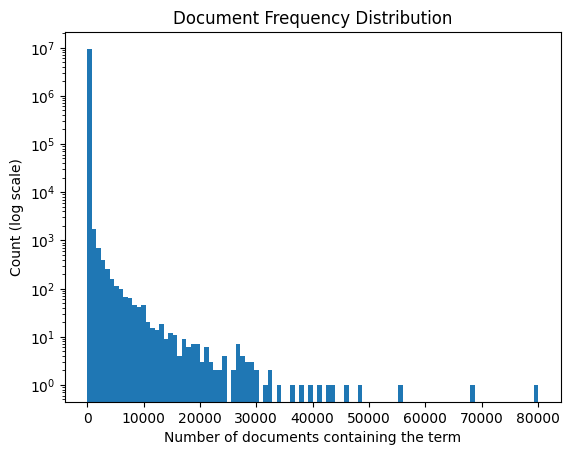

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import matplotlib.pyplot as plt

corpus_df = DATAFRAME
corpus_df["text"] = corpus_df["title"] + " " + corpus_df["abstract"]

vectorizer = TfidfVectorizer(stop_words="english",ngram_range=(1, 2))
X = vectorizer.fit_transform(corpus_df["text"])
print("Df Volume: ", X.shape)

# Zipf law
df = (X > 0).sum(axis=0).A1

plt.hist(df, bins=100, log=True)
plt.title("Document Frequency Distribution")
plt.xlabel("Number of documents containing the term")
plt.ylabel("Count (log scale)")
plt.show()

In [16]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def baseline_retrieve_top_k(query, k=5):
    # TFIDF quety
    q_vec = vectorizer.transform([query])
    # cosine similaruty
    scores = cosine_similarity(q_vec, X)[0]
    top_idx = np.argsort(scores)[-k:][::-1]
    return corpus_df.iloc[top_idx]["pmid"]

## 8. Evaluations:
1. Presicion, Mean prediction
2. Recall
3. F1
4. nDCG




In [17]:
corpus_df.columns

Index(['pmid', 'title', 'abstract', 'text'], dtype='object')

## 9. Preparation

In [18]:
# dict pimd2text
pmid_to_text = {}

for _, row in corpus_df.iterrows():
    pmid = row["pmid"]
    title = str(row["title"])
    abstract = str(row["abstract"])

    pmid_to_text[pmid] = {
        "title": title,
        "abstract": abstract
    }

print("Number of documents in pmid_to_text:", len(pmid_to_text))

Number of documents in pmid_to_text: 163189


In [20]:
# query_dict:
DATA_PATH="Hands-on-NLP-Project"  # ⭐ Change your path
qrels_path = f"{project_path}/relevance_matrix.tsv"  # ⭐ Change your path
qrels_df = pd.read_csv(qrels_path, sep='\t')

df = qrels_df.copy()
df.columns = [c.strip().lower() for c in df.columns]
df = df.dropna(subset=["pmid1", "pmid2", "relevance"])
df = df[df["pmid1"] != df["pmid2"]]

df = (
    df.groupby(["pmid1", "pmid2"], as_index=False)["relevance"]
    .max()
)

# =====  query_dict =====

# {
#   query_pmid: {
#       "docs": {doc_pmid: relevance_score, ...},
#       "relevant_docs": [pmid with relevance >=1],
#       "highly_relevant_docs": [pmid with relevance ==2]
#   }
# }

query_dict = {}
df["pmid1"] = df["pmid1"].astype(str)
df["pmid2"] = df["pmid2"].astype(str)

for _, row in df.iterrows():
    q = row["pmid1"]
    d = row["pmid2"]
    s = int(row["relevance"])

    if q not in query_dict:
        query_dict[q] = {
            "docs": {},
            "relevant_docs": [],
            "highly_relevant_docs": []
        }

    query_dict[q]["docs"][d] = s

    if s >= 1:
        query_dict[q]["relevant_docs"].append(d)

    if s == 2:
        query_dict[q]["highly_relevant_docs"].append(d)




def get_query_text(pmid, mode="full"):
    title = pmid_to_text[pmid]["title"]
    abstract = pmid_to_text[pmid]["abstract"]

    if mode == "title":
        return title
    elif mode == "abstract":
        return abstract
    elif mode == "full":
        return title + " " + abstract
    else:
        raise ValueError("Unknoe mode")


# Valide queries
K=5
N = 20
valid_queries = []
for q, data in query_dict.items():
    # At least 10 documents and at least 1 relevant>=1
    if len(data["docs"]) >= K and len(data["relevant_docs"]) > 0:
        valid_queries.append(q)
print("Valid queries:", len(valid_queries))


Valid queries: 3190


## 10. Evaluation metrics  
⭐：  
The code behind is used for baseline models evluation.  
Please Change your own retrival function "✅" here.

In [22]:
#Presicion
def precision_at_k(retrieved_pmids, query_pmid, k=10, strict=False):
    """
    retrieved_pmids: list of pmids returned by retrieval
    query_pmid: the query pmid
    k: cutoff
    strict:
        False -> relevance >=1 considered relevant
        True  -> only relevance ==2 considered relevant
    """
    retrieved_pmids = retrieved_pmids[:k]
    if query_pmid not in query_dict:
        return 0.0
    relevant_docs = query_dict[query_pmid]["docs"]
    hit = 0
    for pmid in retrieved_pmids:
        if pmid in relevant_docs:
            if strict:
                if relevant_docs[pmid] == 2:
                    hit += 1
            else:
                if relevant_docs[pmid] >= 1:
                    hit += 1
    return hit / k


# Mean precision
def mean_precision_at_k(valid_queries, k=10, strict=False):
    scores = []
    for q in valid_queries:
        query_text = get_query_text(q, mode="full")
        retrieved = baseline_retrieve_top_k(query_text, k=k)  #✅ Chaning your own retrieval function here
        p = precision_at_k(retrieved, q, k=k, strict=strict)
        scores.append(p)
    #return sum(scores) / len(scores)
    return scores



#==============================================================================
# Recall
def recall_at_k(retrieved_pmids, query_pmid, k=10, strict=False):
    """
    retrieved_pmids: list of pmids returned by retrieval
    query_pmid: the query pmid
    k: cutoff
    strict:
        False -> relevance >=1 considered relevant
        True  -> only relevance ==2 considered relevant
    """
    retrieved_pmids = retrieved_pmids[:k]
    if query_pmid not in query_dict:
        return 0.0
    relevant_docs = query_dict[query_pmid]["docs"]
    if strict:
        total_relevant = sum(1 for s in relevant_docs.values() if s == 2)
    else:
        total_relevant = sum(1 for s in relevant_docs.values() if s >= 1)

    if total_relevant == 0:
        return 0.0
    hit = 0
    for pmid in retrieved_pmids:
        if pmid in relevant_docs:
            if strict:
                if relevant_docs[pmid] == 2:
                    hit += 1
            else:
                if relevant_docs[pmid] >= 1:
                    hit += 1
    return hit / total_relevant

# Mean recall
def mean_recall_at_k(valid_queries, k=10, strict=False):
    scores = []
    for q in valid_queries:
        query_text = get_query_text(q, mode="full")
        retrieved = baseline_retrieve_top_k(query_text, k=k) #✅ Chaning your own retrieval function here
        r = recall_at_k(retrieved, q, k=k, strict=strict)
        scores.append(r)
    #return sum(scores) / len(scores)
    return scores


#===============================================================================
# F1
def f1_at_k(retrieved_pmids, query_pmid, k=10, strict=False):
    p = precision_at_k(retrieved_pmids, query_pmid, k=k, strict=strict)
    r = recall_at_k(retrieved_pmids, query_pmid, k=k, strict=strict)
    if p + r == 0:
        return 0.0
    return 2 * p * r / (p + r)

def mean_f1_at_k(valid_queries, k=10, strict=False):
    scores = []
    for q in valid_queries:
        query_text = get_query_text(q, mode="full")
        retrieved = baseline_retrieve_top_k(query_text, k=k) #✅ Chaning your own retrieval function here
        f1 = f1_at_k(retrieved, q, k=k, strict=strict)
        scores.append(f1)
    #return sum(scores) / len(scores)
    return scores



#========================================================================
# nDCG
import numpy as np

def dcg_at_k(retrieved_pmids, query_pmid, k=10, gain_scheme="exp2"):
    """
    gain_scheme:
      - "exp2": gain = 2^rel - 1
      - "linear": gain = rel
    """
    retrieved_pmids = retrieved_pmids[:k]
    if query_pmid not in query_dict:
        return 0.0
    rel_map = query_dict[query_pmid]["docs"]  # {pmid2: relevance(0/1/2)}
    dcg = 0.0
    for i, pmid in enumerate(retrieved_pmids, start=1):  # rank i from 1
        rel = rel_map.get(pmid, 0)

        if gain_scheme == "exp2":
            gain = (2 ** rel) - 1
        elif gain_scheme == "linear":
            gain = rel
        else:
            raise ValueError("gain_scheme must be 'exp2' or 'linear'")
        discount = np.log2(i + 1)
        dcg += gain / discount
    return dcg


def ndcg_at_k(retrieved_pmids, query_pmid, k=10, gain_scheme="exp2"):
    """
    nDCG@k = DCG@k / IDCG@k
    """
    if query_pmid not in query_dict:
        return 0.0
    rel_map = query_dict[query_pmid]["docs"]
    retrieved_pmids = retrieved_pmids[:k]
    # DCG of your ranking
    dcg = dcg_at_k(retrieved_pmids, query_pmid, k=k, gain_scheme=gain_scheme)
    # IDCG: ideal DCG by sorting all labeled docs by relevance desc
    ideal_rels = sorted(rel_map.values(), reverse=True)[:k]
    idcg = 0.0
    for i, rel in enumerate(ideal_rels, start=1):
        if gain_scheme == "exp2":
            gain = (2 ** rel) - 1
        else:  # linear
            gain = rel
        idcg += gain / np.log2(i + 1)
    if idcg == 0:
        return 0.0
    return dcg / idcg


def mean_ndcg_at_k(valid_queries, k=10, gain_scheme="exp2"):
    scores = []
    for q in valid_queries:
        query_text = get_query_text(q, mode="full")
        retrieved = baseline_retrieve_top_k(query_text, k=k) #✅ Chaning your own retrieval function here
        scores.append(ndcg_at_k(retrieved, q, k=k, gain_scheme=gain_scheme))
    #return float(np.mean(scores)) if scores else 0.0
    return scores








In [23]:
# Face to face comparaison between CLS POOLING AND MEAN POOLING
def comparer_modeles(valid_queries, k=10):

    ndcg_cls = []
    ndcg_mean = []
    prec_cls = []
    prec_mean = []

    for q in tqdm(valid_queries, desc="Évaluation en cours"):
        # 1. Prédictions CLS (Ancienne méthode)
        preds_cls = tranformer_retrieve_top_k(q, embeddings_matrix=EMBEDDING_CLS, k=k)

        # 2. Prédictions Mean Pooling (Nouvelle méthode)
        preds_mean = tranformer_retrieve_top_k(q, embeddings_matrix=EMBEDDING_MEAN, k=k)

        # Calcul nDCG
        ndcg_cls.append(ndcg_at_k(preds_cls, q, k=k))
        ndcg_mean.append(ndcg_at_k(preds_mean, q, k=k))

        # Calcul Précision
        prec_cls.append(precision_at_k(preds_cls, q, k=k, strict=False))
        prec_mean.append(precision_at_k(preds_mean, q, k=k, strict=False))

    # Affichage des Résultats
    print("\n" + "="*50)
    print(f"FACE TO FACE RÉSULTS (K={k})")
    print("="*50)
    print(f"Métrique      | [CLS] Pooling | Mean Pooling ")
    print("-" * 50)
    print(f"Mean nDCG@{k: <2} | {np.mean(ndcg_cls):.4f}        | {np.mean(ndcg_mean):.4f}")
    print(f"Precision@{k: <2} | {np.mean(prec_cls):.4f}        | {np.mean(prec_mean):.4f}")
    print("="*50)

    # Détecte le gagnant
    if np.mean(ndcg_mean) > np.mean(ndcg_cls):
        print("💡 Conclusion : Le Mean Pooling améliore les performances de la recherche !")
    else:
        print("💡 Conclusion : Le token [CLS] reste plus performant sur ce modèle spécifique.")

# Lancer le test sur 500 requêtes
comparer_modeles(valid_queries[:500], k=10)

Évaluation en cours: 100%|██████████| 500/500 [01:20<00:00,  6.20it/s]


FACE TO FACE RÉSULTS (K=10)
Métrique      | [CLS] Pooling | Mean Pooling 
--------------------------------------------------
Mean nDCG@10 | 0.5928        | 0.2248
Precision@10 | 0.6362        | 0.2456
💡 Conclusion : Le token [CLS] reste plus performant sur ce modèle spécifique.


In [ ]:
# Save and print results
K = 10
p_at_10 = mean_precision_at_k(valid_queries[:500], k=K, strict=False)
print("Precision@10 (relevance>=1):", sum(p_at_10)/len(p_at_10))
p_at_10_strict = mean_precision_at_k(valid_queries[:500], k=K, strict=True)
print("Precision@10 (relevance==2):", sum(p_at_10_strict)/len(p_at_10_strict))
print("="*100)

r_at_10 = mean_recall_at_k(valid_queries[:500], k=K, strict=False)
print("Recall@10 (relevance>=1):", sum(r_at_10)/len(r_at_10))
r_at_10_strict = mean_recall_at_k(valid_queries[:500], k=K, strict=True)
print("Recall@10 (relevance==2):", sum(r_at_10_strict)/len(r_at_10_strict))
print("="*100)

f1_score_at_k = mean_f1_at_k(valid_queries[:500], k=K, strict=False)
print("F1@10 (relevance>=1):",sum(f1_score_at_k)/len(f1_score_at_k))
f1_score_at_k_strict = mean_f1_at_k(valid_queries[:500], k=K, strict=True)
print("F1@10 (relevance==2):",sum(f1_score_at_k_strict)/len(f1_score_at_k_strict))
print("="*100)

mean_ndcg_at_k = mean_ndcg_at_k(valid_queries[:500], k=K)
print("mean nDCG@10:", sum(mean_ndcg_at_k)/len(mean_ndcg_at_k))


## 11. Plot
This script generate automatically:   
Distribution  
Boxplot  

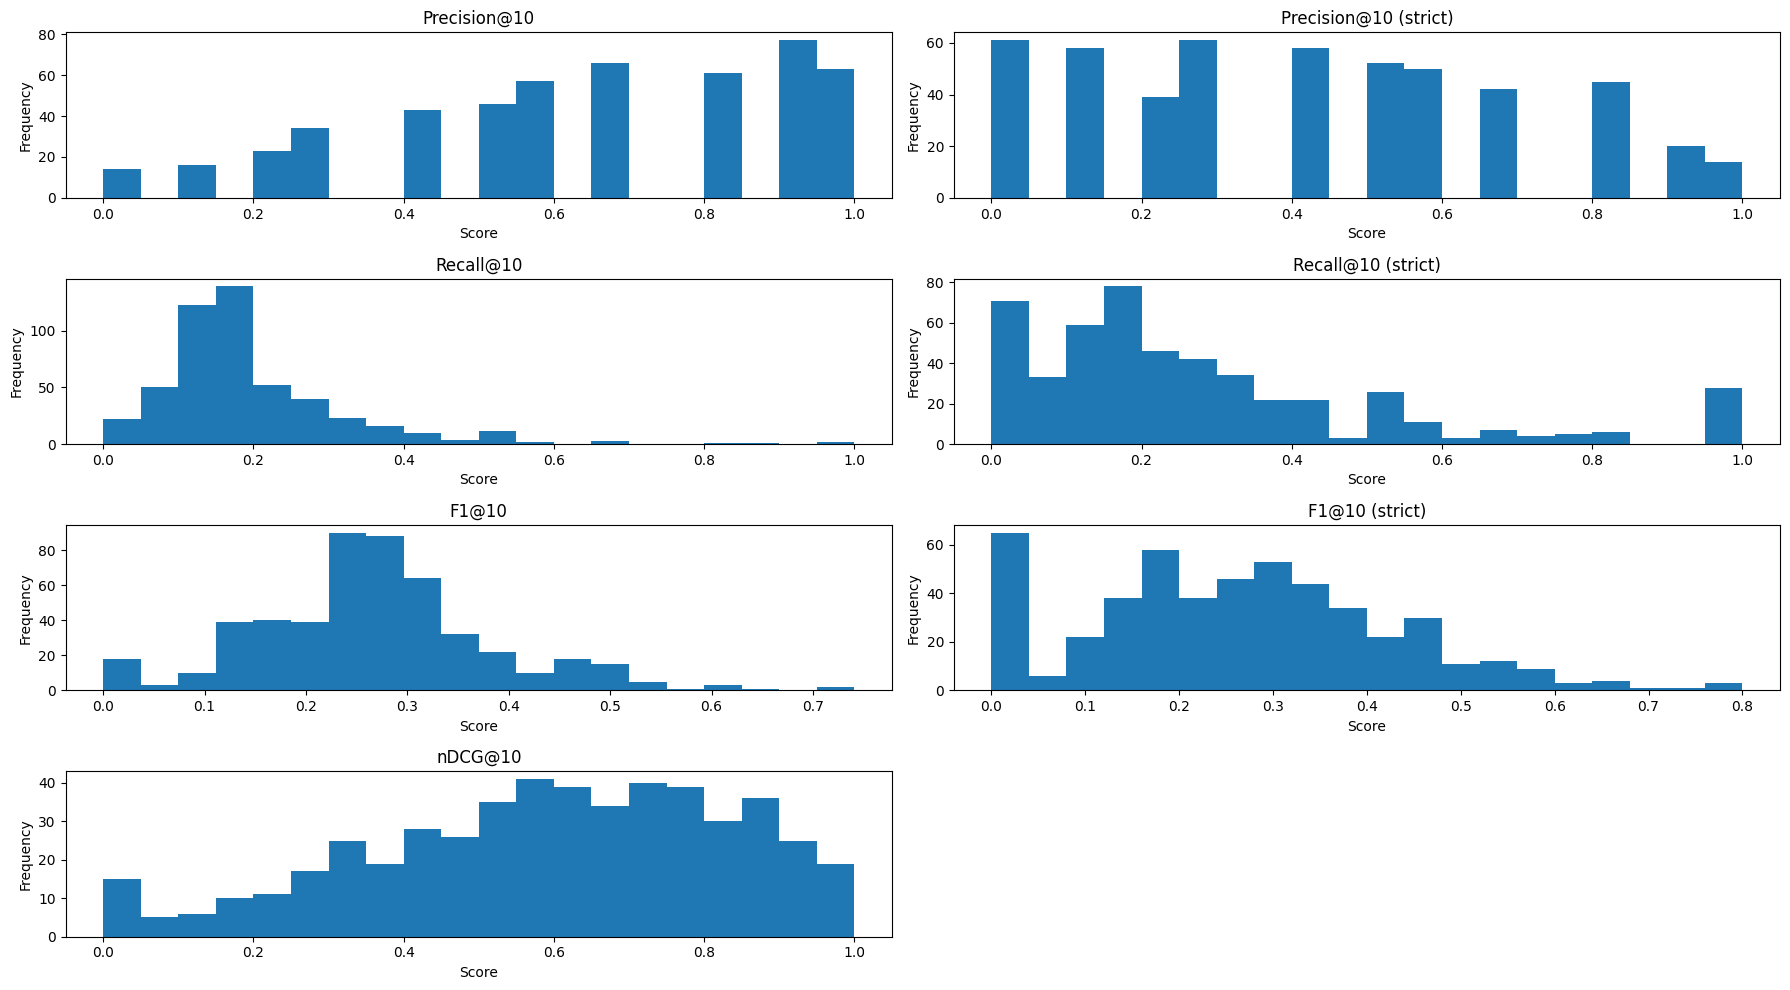

In [ ]:
import matplotlib.pyplot as plt
metrics = {
    "Precision@10": p_at_10,
    "Precision@10 (strict)": p_at_10_strict,
    "Recall@10": r_at_10,
    "Recall@10 (strict)": r_at_10_strict,
    "F1@10": f1_score_at_k,
    "F1@10 (strict)": f1_score_at_k_strict,
    "nDCG@10": mean_ndcg_at_k
}

plt.figure(figsize=(18, 10))
for i, (name, values) in enumerate(metrics.items()):
    plt.subplot(4, 2, i+1)
    plt.hist(values, bins=20)
    plt.title(name)
    plt.xlabel("Score")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


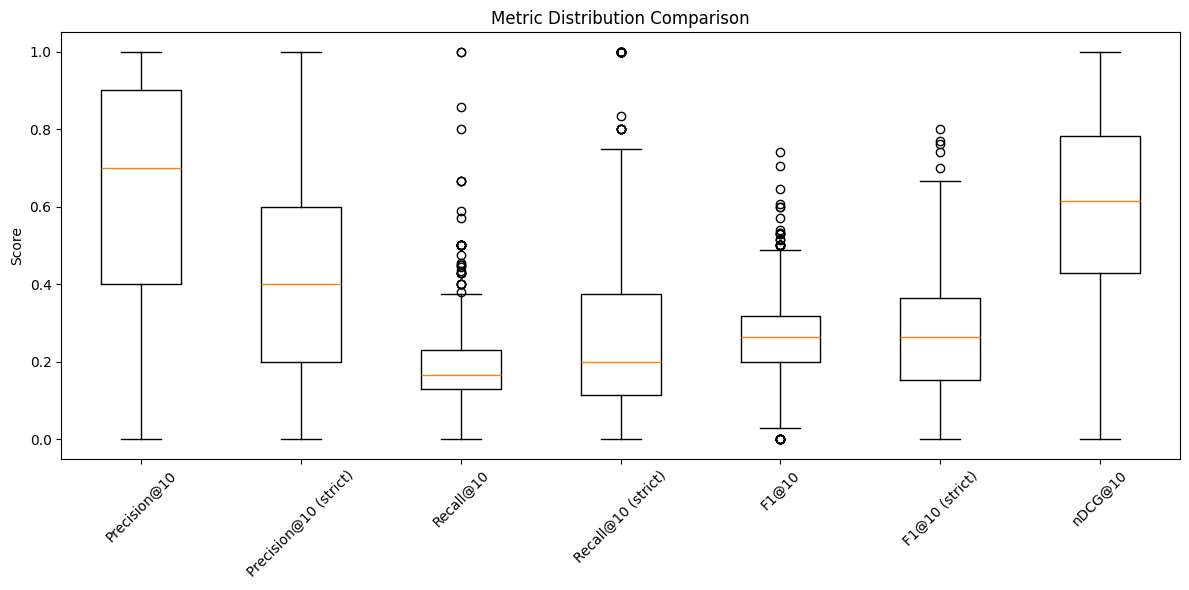

In [ ]:
plt.figure(figsize=(12, 6))

plt.boxplot(metrics.values())
plt.xticks(range(1, len(metrics)+1), metrics.keys(), rotation=45)
plt.ylabel("Score")
plt.title("Metric Distribution Comparison")

plt.tight_layout()
plt.show()
